<h1><center>Optimal transport</center></h1>

Take a look at [ot docs](https://pot.readthedocs.io/en/stable/)
to see the docs of the **ot library**. This notebook deals with the numerical expirementation presented by Gabriele Martine in chapter 3 of her Magister Thesis: *The optimal transpor problem and its application to dissipative partial differential equations* (McGill University, Quebéc, April 2015). The Thesis can be downloaded at   [thesis](http://digitool.library.mcgill.ca/webclient/StreamGate?folder_id=0&dvs=1575237802552~632)

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss

## Two distributions

The normalizer factor is to ensure the two distributions have equal mass

In [50]:
nn = 1001
x = np.linspace(-1, 1, nn)
pdf1, pdf2 = 1+ np.sin(8*x), np.exp(-x)
normalizer = np.sum(pdf2)/np.sum(pdf1)
pdf1 *= normalizer

(0, 2.8)

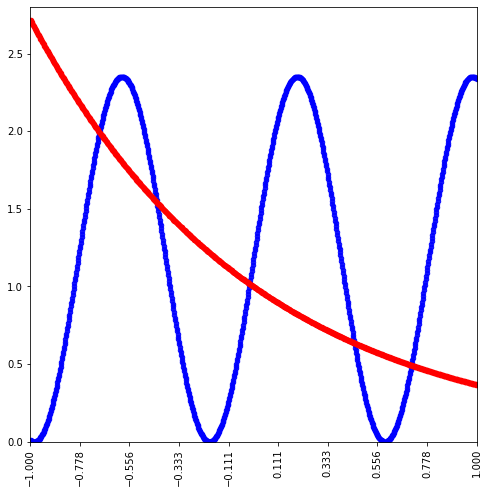

In [51]:
ticks = np.linspace(-1, 1, 10)
fig, ax = plt.subplots(1, 1,figsize=(8, 8))
ax.scatter(x, pdf1,alpha=0.9, s = 20, c = 'b')
ax.scatter(x,pdf2, alpha=0.9, s = 20, c = 'r')
plt.xticks(ticks, rotation='vertical' )
ax.set_xlim([-1, 1])
ax.set_ylim([0, 2.8])

## The discrete transport plan $T$

The cost function is given by the squared distance $M$

In [52]:
M = ot.dist(x.reshape((nn, 1)), x.reshape((nn, 1)))
G0 = ot.emd(pdf1, pdf2, M)
T = G0.transpose()

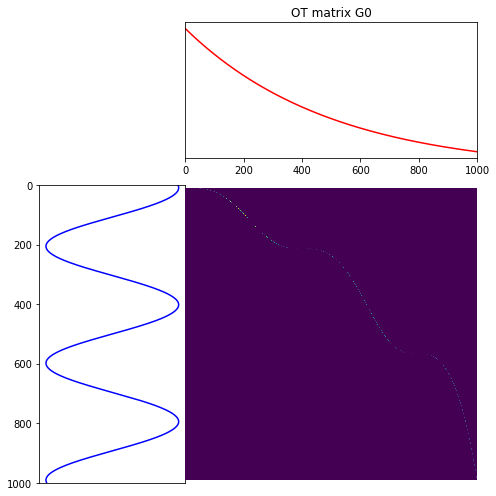

In [53]:
plt.figure( figsize=(7, 7))
ot.plot.plot1D_mat(pdf1, pdf2, T, 'OT matrix G0')

## Fake dynamics simulating the continuous transition between *pdf1* and *pdf2*  


In [54]:
tol = 1/(nn**4)
def lista(t):
    lista  = np.array([((1-t)*x[j] + t*x[i],  T[i,j],) \
          for i in range (nn) for j in range(nn) if  T[i,j]> tol])
    lista = lista[lista[:,0].argsort()]
    zl = [z[0] for z in lista]
    Tl = [z[1] for z in lista]
    return (zl, Tl)

(0.0, 3)

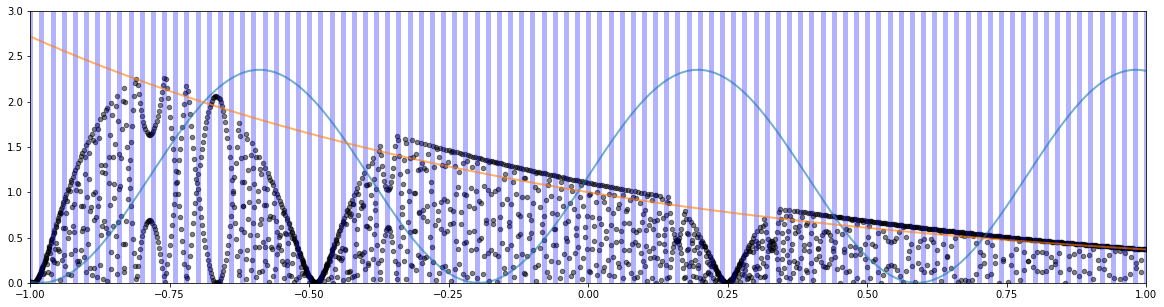

In [63]:
zl, Tl = lista(0.75)
fig, ax = plt.subplots(1, 1,figsize=(20, 5))
#for z in x:
   # ax.vlines(z,0,3, alpha=0.3, colors='b',linewidths=10)   
#for z in zl:
    #ax.vlines(z,0,3, alpha=0.3, colors='r', linewidths=3)  
    
for z in x[list(range(0,nn,10) )]:
    ax.vlines(z,0,3, alpha=0.3, colors='b', linewidths=5)  
ax.scatter( zl, Tl,alpha=0.5, s = 20 , c = 'k')
ax.plot(x, pdf1, lw=2, alpha=0.6)
ax.plot(x, pdf2,   lw = 2, alpha=0.6)
ax.set_xlim([-1, 1])
ax.set_ylim([0.0, 3])

# Clusters

In [42]:
def threshold(t):
    lst = lista(t)[0]
    dif = np.diff(lst)
    return np.sort([z for z in dif if z>t/(2*nn**5)])[0] 

In [43]:
def decant(t):
    lst = lista(t)[0]
    dif = np.diff(lst) 
    thrh = np.sort([z for z in dif if z>t/(2*nn**5)])[0] 
    return (dif<thrh+tol).nonzero()[0]

In [44]:
def clusters(t):
    Lista = lista(t)
    zl = Lista[0]
    dif = np.diff(zl)
    threshold = np.sort([z for z in dif if z>t/(2*nn**5)])[0] 
    indxs = (dif<threshold + tol).nonzero()[0]
    Clsts = []
    j = 0
    while j < len(indxs):
        cl  = []
        m = 0
        while ((indxs[j]+ m) in indxs):
            cl.append(indxs[j]+ m)
            m = m+1
        cl.append(indxs[j]+m)
        Clsts.append(cl)
        j = j+m
    return (Lista,Clsts)

In [45]:
def interpolationDistribution(t):
    Lista, Clsts = clusters(t)
    zl, Tl = Lista[0], Lista[1]
    clusters_indexes  = [n for cl  in Clsts for n in cl]
    main_indexes =[n for n in range(len(zl)) if n not in clusters_indexes]
    main_zpoints = [zl[n] for n in main_indexes ]
    main_Tvalues = [Tl[n] for n in main_indexes]
    def pack_cluster(cl):
        nDat = len(cl)
        z  = np.array([zl[n] for n in cl]).sum()/nDat
        T  = np.array([Tl[n] for n in cl]).sum() 
        return (z, T )
        
    pack = [pack_cluster(cl ) for cl in Clsts]
    z_pack = [p[0] for p in pack]
    T_pack = [p[1] for p in pack]
    return (main_zpoints,  main_Tvalues, z_pack, T_pack)

In [46]:
def show_interpolationDistribution(t):
    main_zpoints,  main_Tvalues, z_pack, T_pack = interpolationDistribution(t)
    fig, ax = plt.subplots(1, 1,figsize=(20, 5))#for z in x:
   #for z in x:
       # ax.vlines(z,0,3, alpha=0.3, colors='b',linewidths=10)   
    for z in z_pack:
        ax.vlines(z,0,3, alpha=0.3, colors='r', linewidths=3)    
    ax.scatter( main_zpoints, main_Tvalues,alpha=1, s = 10 , c = 'k')
    ax.scatter( z_pack, T_pack,alpha=1, s = 10 , marker= '*' , c = 'k')
    ax.plot(x, pdf1, lw=2, alpha=0.6)
    ax.plot(x, pdf2,   lw = 2, alpha=0.6)
    ax.set_xlim([-1, 1])
    ax.set_ylim([0.0, 3])

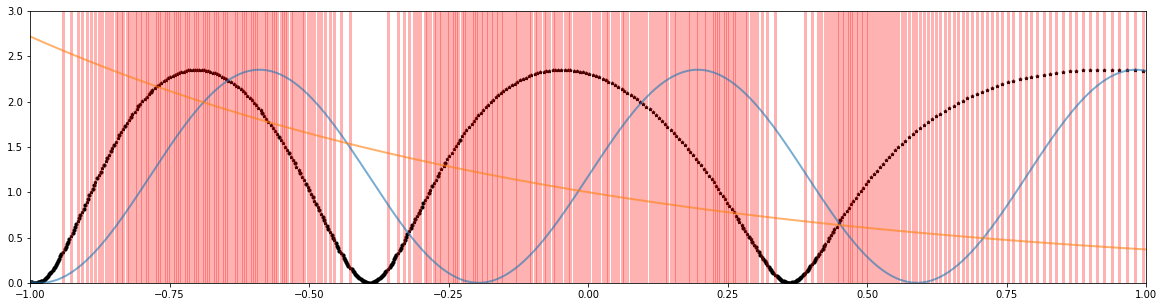

In [49]:
show_interpolationDistribution(0.4999)

## Annotations

In [ ]:
x_ticks = np.linspace(-1, 1, 11)
fig, ax = plt.subplots(1, 1,figsize=(20, 20))
#ax.vlines(0.003361344537814892,0,3, alpha=0.3, colors='g',linewidths=20) 
#for s in x_ticks:
    #ax.vlines(s,0,3, alpha=0.3, colors='b',linewidths=10)
    
#for z in lista(0.6)[55000:85000]:
    #ax.vlines(z,0,3, alpha=0.3, colors='r', linewidths=3) 
#plt.hist(lst, 100, facecolor='g', alpha=0.15) 
plt.hist(z,nn, facecolor='b', alpha=0.35) 
#lt.hist(lst1, 100, facecolor='r', alpha=0.15) 
plt.xticks(x_ticks, rotation='vertical' )    
ax.set_xlim([-1, 1])
ax.set_ylim([0.0, 5]) 

In [ ]:
track = []
post = []
p, j = 1,0
for i in range(1,nn,1):
    j, sum = 0,0
    while (z[p+j] < x[i]):
        sum += Tl[p+j]
        j += 1
    p += j 
    track.append(sum)
    post.append(p)    

In [ ]:
z, Tl = lista(0.4)

In [ ]:
zh = x + 0.4*2/nn
zht = zh[:nn-1]
zht[0]

In [ ]:
ticks = np.linspace(-1, 1, 10)
fig, ax = plt.subplots(1, 1,figsize=(8, 8))
ax.scatter(x, pdf1,alpha=0.9, s = 5, c = 'b')
ax.scatter(x,pdf2, alpha=0.9, s = 5, c = 'r')
ax.scatter(zht,track, alpha=0.9, s = 20, c = 'g')
plt.xticks(ticks, rotation='vertical' )
ax.set_xlim([-1, 1])
ax.set_ylim([0, 3])